In [645]:
import pandas as pd
import calibrate
import simulate
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import simulate

In [581]:
class HawkesProcessCalibrator:
    def __init__(self, events):
        self.events = events

    def calibrate(self):
        res = minimize(fun=self.nll, x0=[1,1,2], bounds=[(1e-10, None), (1e-10, None), (1e-10, None)], method='L-BFGS-B')
        return res.x
    
    def nll(self, theta):
        # source: https://www.ism.ac.jp/editsec/aism/pdf/031_1_0145.pdf
        mu, alpha, beta = theta
        kappa = alpha/beta
        t_n = self.events[-1]
        n = len(self.events)
        ll = t_n - mu * t_n
        for i in range(n):
            ll = ll - kappa * (1 - np.exp(-beta*(t_n - self.events[i])))

        r_array = np.zeros(n)
        for i in range(1, n):
            r_array[i] = np.exp(-beta * (self.events[i] - self.events[i - 1])) * (1 + r_array[i - 1])

        for i in range(n):
            ll += np.log(mu + alpha*r_array[i])
        return -ll

In [582]:
mu, alpha, beta = 0.5, 0.2, 0.8
hwk_proc = simulate.HawkesProcess(mu, alpha, beta)
T = 1000
events = hwk_proc.simulate(T)
intensity_func = lambda t: hwk_proc.get_rate(events, t)

# # plot the events
# plt.figure()
# plt.plot(events, [0]*len(events), 'x')
# t_range = np.linspace(0, T, 1000)
# intensity = [intensity_func(t) for t in t_range]
# plt.plot(t_range, intensity)
# plt.show()

In [583]:
cal = HawkesProcessCalibrator(events)
mu, alpha, beta = cal.calibrate()
print("Calibrated mu, alpha, beta: ", mu, alpha, beta)
print("True mu, alpha, beta: ", hwk_proc.mu, hwk_proc.alpha, hwk_proc.beta)

print("log-likelihood of true parameters: ", -cal.nll([hwk_proc.mu, hwk_proc.alpha, hwk_proc.beta]))
print("log-likelihood of calibrated parameters: ", -cal.nll([mu, alpha, beta]))

Calibrated mu, alpha, beta:  0.48812435784324903 0.09799020034362958 0.4555271537376123
True mu, alpha, beta:  0.5 0.2 0.8
log-likelihood of true parameters:  86.56470841792077
log-likelihood of calibrated parameters:  89.16118400802222


In [751]:
class MultiHawkesProcessCalibrator:
    def __init__(self, events, d):
        self.events = events
        self.d = d

    def calibrate(self, initial_guess_flat, T):
        bounds = [(1e-10, 10)] * self.d + [(1e-10, 10)] * self.d**2 + [(1e-10, 10)] * self.d**2
        res = minimize(fun=self.nll_d, args=(T, ), x0=initial_guess_flat, bounds=bounds, method='L-BFGS-B')
        return res.x
    
    def nll_2d(self, theta, T):
        mus = theta[:self.d]
        alphas = theta[self.d:self.d + self.d**2].reshape((self.d, self.d))
        betas = theta[self.d + self.d**2:].reshape((self.d, self.d))
        ll_1 = -mus[0] * T
        ll_2 = -mus[1] * T
        n = np.max([len(self.events[i]) for i in range(self.d)])
        r = np.zeros((self.d, self.d, n))
        l = 0
        for k in range(1, len(self.events[0])):
            r[0, 0, k] = np.exp(-betas[0, 0] * (self.events[0][k] - self.events[0][k - 1])) * (1 + r[0, 0, k - 1])
            l = 0
            sum_k01 = 0
            while l < len(self.events[1]) and self.events[0][k - 1] <= self.events[1][l] and self.events[1][l] < self.events[0][k]:
                sum_k01 += np.exp(-betas[0, 1] * (self.events[0][k] - self.events[1][l]))
                l += 1
            r[0, 1, k] = np.exp(-betas[0, 1] * (self.events[0][k] - self.events[0][k - 1])) * (1 + r[0, 1, k - 1]) + sum_k01
        for k in range(1, len(self.events[1])):
            r[1, 1, k] = np.exp(-betas[1, 1] * (self.events[1][k] - self.events[1][k - 1])) * (1 + r[1, 1, k - 1])
            l = 0
            sum_k10 = 0
            while l < len(self.events[0]) and self.events[1][k - 1] <= self.events[0][l] and self.events[0][l] < self.events[1][k]:
                sum_k10 += np.exp(-betas[1, 0] * (self.events[1][k] - self.events[0][l]))
                l += 1
            r[1, 0, k] = np.exp(-betas[1, 0] * (self.events[1][k] - self.events[1][k - 1])) * (1 + r[1, 0, k - 1]) + sum_k10

        for k in range(len(self.events[0])):
            ll_1 = ll_1 - (alphas[0, 0] / betas[0, 0]) * (1 - np.exp(-betas[0, 0]*(T - self.events[0][k])))
            ll_1 = ll_1 - (alphas[0, 1] / betas[0, 1]) * (1 - np.exp(-betas[0, 1]*(T - self.events[0][k])))
            ll_1 = ll_1 + np.log(mus[0] + alphas[0, 0] * r[0, 0, k] + alphas[0, 1] * r[0, 1, k])

        for k in range(len(self.events[1])):
            ll_2 = ll_2 - (alphas[1, 0] / betas[1, 0]) * (1 - np.exp(-betas[1, 0]*(T - self.events[1][k])))
            ll_2 = ll_2 - (alphas[1, 1] / betas[1, 1]) * (1 - np.exp(-betas[1, 1]*(T - self.events[1][k])))
            ll_2 = ll_2 + np.log(mus[1] + alphas[1, 0] * r[1, 0, k] + alphas[1, 1] * r[1, 1, k])

        return -(ll_1 + ll_2)

    def nll_d(self, theta, T):
        # source: https://www.ism.ac.jp/editsec/aism/pdf/031_1_0145.pdf
        mus = theta[:self.d]
        alphas = theta[self.d:self.d + self.d**2].reshape((self.d, self.d))
        betas = theta[self.d + self.d**2:].reshape((self.d, self.d))
        n = np.max([len(self.events[i]) for i in range(self.d)])
        ll = np.zeros(self.d)
        for i in range(self.d):
            ll[i] = T - mus[i] * T
            # ll[i] = -mus[i] * T
            for k in range(len(self.events[i])):
                for j in range(self.d):
                    ll[i] = ll[i] - (alphas[i, j] / betas[i, j]) * (1 - np.exp(-betas[i, j]*(T - self.events[i][k])))
        
        r_array = np.zeros((self.d, self.d, n))
        for i in range(self.d):
            for k in range(1, len(self.events[i])):
                for j in range(self.d):
                    if i==j:
                        r_array[i, j, k] = np.exp(-betas[i, j] * (self.events[i][k] - self.events[i][k - 1])) * (1 + r_array[i, j, k - 1])
                    else:
                        sum = 0
                        l = 0
                        while l < len(self.events[j]) and self.events[j][l] >= self.events[i][k - 1] and self.events[j][l] < self.events[i][k]:
                            sum += np.exp(-betas[i, j] * (self.events[i][k] - self.events[j][l]))
                            l += 1
                        r_array[i, j, k] = np.exp(-betas[i, j] * (self.events[i][k] - self.events[i][k - 1])) * (1 + r_array[i, j, k - 1]) + sum

        for i in range(self.d):
            for k in range(len(self.events[i])):
                sum_rk = 0
                for j in range(self.d):
                    sum_rk += alphas[i, j] * r_array[i, j, k]
                ll[i] += np.log(mus[i] + sum_rk)  
                #     r_ijk = 0
                #     l = 0
                #     while l < len(events[j]) and events[j][l] < events[i][k]:
                #         r_ijk += np.exp(-betas[i, j] * (events[i][k] - events[j][l]))
                #         l += 1
                #     sum_rk += alphas[i, j] * r_ijk
                # ll[i] += np.log(mus[i] + sum_rk)  

        return -np.sum(ll)

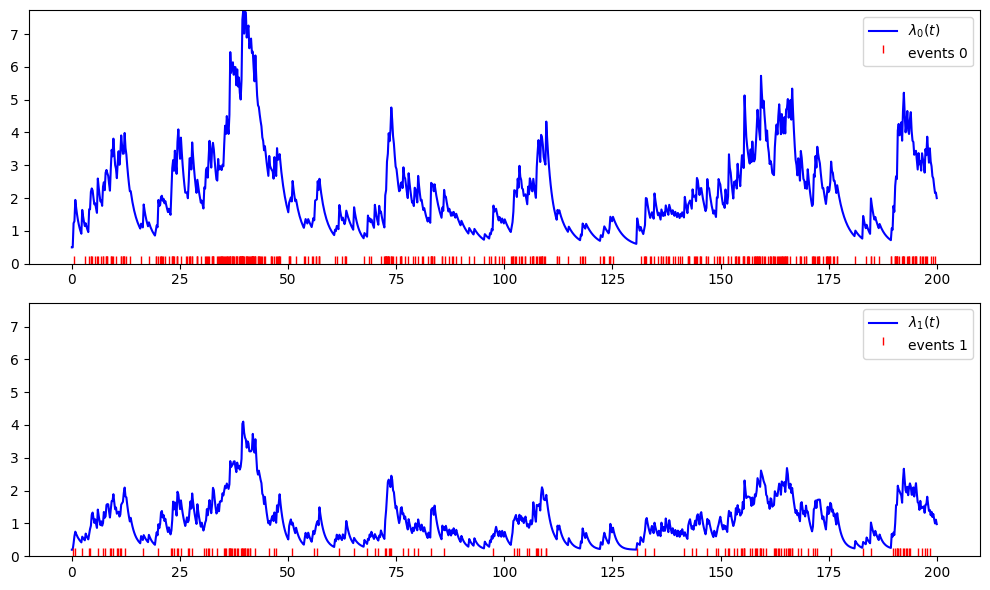

In [752]:
d = 2

mus = [0.5, 0.2]
alphas = [[0.2, 0.8], [0.25, 0.2]]
betas = [[0.4, 1], [1, 0.5]]

multi_hawkes = simulate.MultiHawkesProcess(mus, alphas, betas)
T = 200
events = multi_hawkes.simulate(T)
multi_hawkes.plot(events, T)

In [753]:
cal_2D = MultiHawkesProcessCalibrator(events, d)

In [754]:
mus_initial = [1, 1]
alphas_initial = [[0.5, 0.5], [0.5, 0.5]]
betas_initial = [[1, 1], [1, 1]]

initial_guess_flat = np.concatenate([np.array(mus_initial).flatten(), np.array(alphas_initial).flatten(), np.array(betas_initial).flatten()])

In [755]:
theta = cal_2D.calibrate(initial_guess_flat, T)

In [756]:
mus_hat = theta[:d]
alphas_hat = theta[d:d + d**2].reshape((d, d))
betas_hat = theta[d + d**2:].reshape((d, d))

In [757]:
true_alphas = multi_hawkes.alphas

mus_values = multi_hawkes.mus
mus_estimates = mus_hat
mus_names = [f'mu_{i+1}' for i in range(len(mus_values))]

mus_comparison_df = pd.DataFrame({
    'Mu True': mus_values,
    'Mu Estimate': mus_estimates
}, index=mus_names)

print("Comparison of Mus:")
print(mus_comparison_df, '\n')

# Create DataFrame for alpha values and estimates
alpha_values = []
alpha_estimates = []
alpha_names = []
for i in range(len(true_alphas)):
    for j in range(len(true_alphas[i])):
        alpha_values.append(true_alphas[i][j])
        alpha_estimates.append(alphas_hat[i][j])
        alpha_names.append(f'alpha_{i+1}{j+1}')

alpha_comparison_df = pd.DataFrame({
    'Alpha True': alpha_values,
    'Alpha Estimate': alpha_estimates
}, index=alpha_names)

print("Comparison of Alphas:")
print(alpha_comparison_df, '\n')

true_betas = multi_hawkes.betas
betas_hat = betas_hat

# Create DataFrame for beta values and estimates
beta_values = []
beta_estimates = []
beta_names = []
for i in range(len(true_betas)):
    for j in range(len(true_betas[i])):
        beta_values.append(true_betas[i][j])
        beta_estimates.append(betas_hat[i][j])
        beta_names.append(f'beta_{i+1}{j+1}')

beta_comparison_df = pd.DataFrame({
    'Beta True': beta_values,
    'Beta Estimate': beta_estimates
}, index=beta_names)

print("\nComparison of Betas:")
print(beta_comparison_df)


Comparison of Mus:
      Mu True  Mu Estimate
mu_1      0.5     0.703200
mu_2      0.2     0.240115 

Comparison of Alphas:
          Alpha True  Alpha Estimate
alpha_11        0.20    2.019224e-01
alpha_12        0.80    2.019281e-01
alpha_21        0.25    3.022616e-01
alpha_22        0.20    1.000000e-10 


Comparison of Betas:
         Beta True  Beta Estimate
beta_11        0.4       0.592560
beta_12        1.0       0.592566
beta_21        1.0       0.425259
beta_22        0.5       0.447869


In [758]:
print("Calibrated mus: ", mus_hat)
print("True mus: ", multi_hawkes.mus, "\n")

print("Calibrated alphas: ", alphas_hat)
print("True alphas: ", multi_hawkes.alphas, "\n")

print("Calibrated betas: ", betas_hat)
print("True betas: ", multi_hawkes.betas)

Calibrated mus:  [0.70320049 0.24011489]
True mus:  [0.5, 0.2] 

Calibrated alphas:  [[2.01922437e-01 2.01928116e-01]
 [3.02261622e-01 1.00000000e-10]]
True alphas:  [[0.2, 0.8], [0.25, 0.2]] 

Calibrated betas:  [[0.59256039 0.59256586]
 [0.42525865 0.44786908]]
True betas:  [[0.4, 1], [1, 0.5]]


In [759]:
print("log-likelihood of true parameters: ", -cal_2D.nll_d(np.concatenate([np.array(multi_hawkes.mus).flatten(), np.array(multi_hawkes.alphas).flatten(), np.array(multi_hawkes.betas).flatten()]), T))
print("log-likelihood of calibrated parameters: ", -cal_2D.nll_d(theta, T))

log-likelihood of true parameters:  125.6934536236459
log-likelihood of calibrated parameters:  179.25757804541422
